Ran a bunch of score functions. Look at how they differ in predicting peptide binding. Ran:
- ```ref2015```
- ```ref2015_cst```
- ```score12```
- ```docking```

In [2]:
from os import listdir
import pandas as pd

In [20]:
score_names = [
    'ref2015',
    'ref2015_cst',
    'score12',
    'docking'
]

kds = {'peptide86':0.7E-9,
           'peptide78':3.4E-9,
           'peptide79':8.5E-9,
           'peptide99':1.8E-7,
           'peptide128':2.8E-7,
           'native_test':0.9E-6,
           'peptide104':1.3E-6,
           'peptide101':2.5E-6,
           'peptide114':1.9E-4
           }

folder = './decoys/'
frames = []

for d in score_names:
    path = folder+d+'/'
    jsons = listdir(path)
    for f in jsons:
        if '.json' in f:
            df = pd.read_json(path+f, orient='records', lines=True)
            df['sfxn'] = d
            name = f.split('.')[0]
            df['peptide'] = name
            df['kd'] = kds[name]
            frames.append(df)
#     data = pd.read_json(path+score_names[0]+"/", orient='records', lines=True)
#     for f in fascs[1:]:
#         d = pd.read_json("./decoys/"+f, orient='records', lines=True)
#         data = data.append(d)

In [21]:
data = pd.concat(frames)

In [7]:
from plotnine import *

/home/colin/anaconda3/envs/pyrosetta/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/colin/anaconda3/envs/pyrosetta/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/colin/anaconda3/envs/pyrosetta/lib/

In [26]:
data.columns

Index(['A_B binding energy', 'fa_atr', 'fa_rep', 'fa_sol', 'fa_intra_rep',
       'fa_intra_sol_xover4', 'lk_ball_wtd', 'fa_elec', 'pro_close',
       'hbond_sr_bb', 'hbond_lr_bb', 'hbond_bb_sc', 'hbond_sc', 'dslf_fa13',
       'omega', 'fa_dun', 'p_aa_pp', 'yhh_planarity', 'ref', 'rama_prepro',
       'total_score', 'sfxn', 'peptide', 'kd', 'atom_pair_constraint',
       'coordinate_constraint', 'angle_constraint', 'dihedral_constraint',
       'metalbinding_constraint', 'chainbreak', 'res_type_constraint',
       'fa_pair', 'dslf_ss_dst', 'dslf_cs_ang', 'dslf_ss_dih', 'dslf_ca_dih',
       'rama'],
      dtype='object')

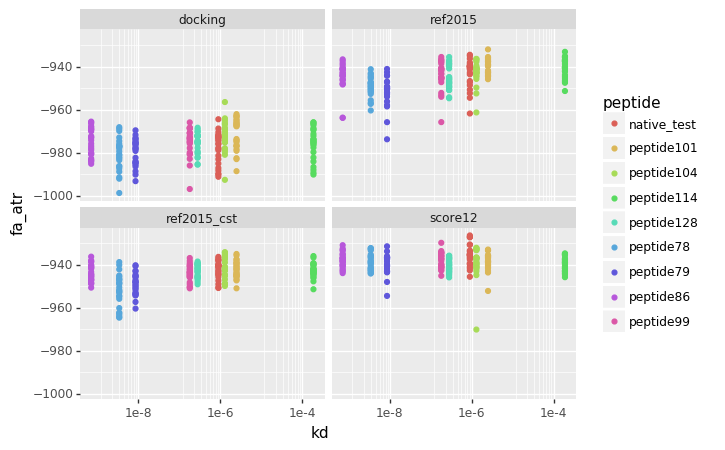

<ggplot: (8762579164913)>

In [30]:
(ggplot(data)
     + aes('kd', 'fa_atr')
     + aes(color='peptide')
     + geom_point()
#     + stat_smooth()
     + facet_wrap('~sfxn')
     + scale_x_log10()
)

In [47]:
for s in score_names:
    print(s)
    print(data[data['sfxn']==s].corr('pearson')['kd'][['A_B binding energy', 'fa_atr', 'total_score']])

ref2015
A_B binding energy    0.037174
fa_atr                0.221345
total_score          -0.141916
Name: kd, dtype: float64
ref2015_cst
A_B binding energy    0.076429
fa_atr                0.121068
total_score          -0.010850
Name: kd, dtype: float64
score12
A_B binding energy   -0.039233
fa_atr               -0.092195
total_score           0.054285
Name: kd, dtype: float64
docking
A_B binding energy   -0.033666
fa_atr                0.011873
total_score          -0.127774
Name: kd, dtype: float64


take the top 5 scoring decoys:

In [36]:
peptides = set(data['peptide'])

topl = []
t = 5

for p in peptides:
    for s in score_names:
        sor = data[(data['peptide']==p) & (data['sfxn']==s)].sort_values('total_score')
        topl.append(sor[:t])
    
top = pd.concat(topl)

In [37]:
top.shape

(180, 37)

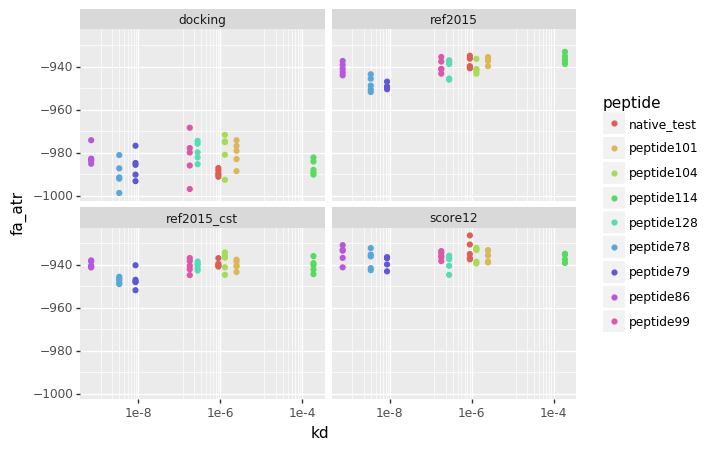

<ggplot: (8762566210621)>

In [80]:
(ggplot(top)
     + aes('kd', 'fa_atr')
     + aes(color='peptide')
     + geom_point()
#     + stat_smooth()
     + facet_wrap('~sfxn')
     + scale_x_log10()
)

In [81]:
for s in score_names:
    print(s)
    print(top[top['sfxn']==s].corr('pearson')['kd'][['A_B binding energy', 'fa_atr', 'total_score', 'ref']])

ref2015
A_B binding energy    0.252533
fa_atr                0.365582
total_score          -0.340817
ref                  -0.038768
Name: kd, dtype: float64
ref2015_cst
A_B binding energy    0.234067
fa_atr                0.105581
total_score           0.166985
ref                  -0.038768
Name: kd, dtype: float64
score12
A_B binding energy    0.177508
fa_atr               -0.007856
total_score           0.062943
ref                   0.140814
Name: kd, dtype: float64
docking
A_B binding energy    0.023049
fa_atr               -0.146347
total_score          -0.154242
ref                        NaN
Name: kd, dtype: float64


Looks like ```ref2015``` is the best here with ```fa_atr```. Good to have that squared away. Let's take a closer look at those results.

In [64]:
df_ref2015 = data[data['sfxn']=='ref2015']
df_ref2015_top = top[top['sfxn']=='ref2015']
df_ref2015_top.shape

(45, 37)

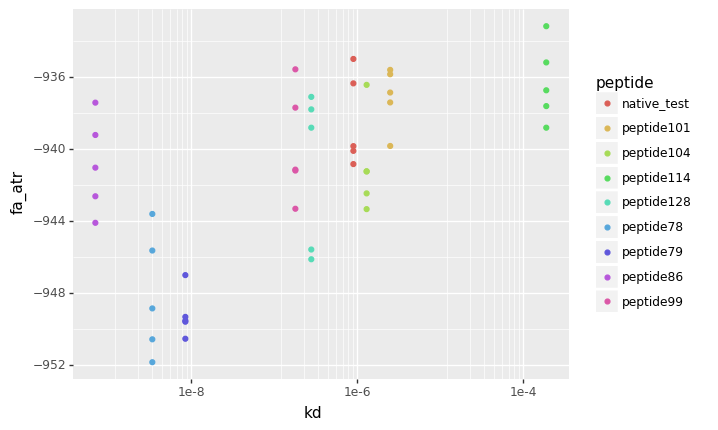

<ggplot: (8762565869477)>

In [78]:
(
ggplot(df_ref2015_top)
    + aes('kd', 'fa_atr')
    + aes(color='peptide')
    + geom_point()
    + scale_x_log10()
#    + stat_smooth(method='lm')
)

In [68]:
df_ref2015_top.corr('pearson')['kd']

A_B binding energy         0.252533
fa_atr                     0.365582
fa_rep                    -0.270902
fa_sol                    -0.367466
fa_intra_rep              -0.068334
fa_intra_sol_xover4       -0.083184
lk_ball_wtd                0.068409
fa_elec                    0.017174
pro_close                 -0.169906
hbond_sr_bb                0.070754
hbond_lr_bb                0.074496
hbond_bb_sc                0.087544
hbond_sc                  -0.197593
dslf_fa13                       NaN
omega                     -0.120891
fa_dun                    -0.290804
p_aa_pp                   -0.022299
yhh_planarity             -0.042972
ref                       -0.038768
rama_prepro               -0.020669
total_score               -0.340817
kd                         1.000000
atom_pair_constraint            NaN
coordinate_constraint           NaN
angle_constraint                NaN
dihedral_constraint             NaN
metalbinding_constraint         NaN
chainbreak                  

In [76]:
df_ref2015_top[
    (df_ref2015_top['peptide'] != 'peptide86') 
#    & (df_ref2015_top['peptide'] != 'peptide114')
].corr('pearson')['kd']

A_B binding energy         0.255032
fa_atr                     0.377784
fa_rep                    -0.278351
fa_sol                    -0.385135
fa_intra_rep              -0.079524
fa_intra_sol_xover4       -0.099979
lk_ball_wtd                0.089649
fa_elec                    0.023180
pro_close                 -0.173415
hbond_sr_bb                0.081324
hbond_lr_bb                0.096674
hbond_bb_sc                0.088701
hbond_sc                  -0.212944
dslf_fa13                       NaN
omega                     -0.134971
fa_dun                    -0.313843
p_aa_pp                   -0.039611
yhh_planarity             -0.062687
ref                       -0.014625
rama_prepro               -0.021646
total_score               -0.348725
kd                         1.000000
atom_pair_constraint            NaN
coordinate_constraint           NaN
angle_constraint                NaN
dihedral_constraint             NaN
metalbinding_constraint         NaN
chainbreak                  